# Clean dataset using influence functions and neural networks


This notebook cares about how to calculate the most influential points for the wine classification dataset.

In [2]:
from sklearn.datasets import load_wine
from valuation.utils.dataset import Dataset

wine_bunch = load_wine(as_frame=True)
dataset = Dataset.from_sklearn(wine_bunch)

is straightforward using python. As usual a closer inspection of the data is helpful. The data is plotted by the following function.

/home/markus/miniconda3/envs/valuation/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


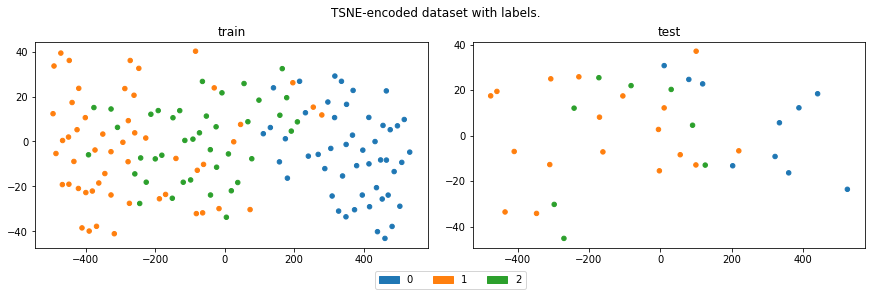

In [3]:
from valuation.utils import dataset_tsne_encode, dataset_to_json
from valuation.utils.plotting import plot_datasets

tsne_dataset = dataset_tsne_encode(dataset)
tsne_dateset_json = dataset_to_json(tsne_dataset)
plot_datasets(tsne_dateset_json, s=20, suptitle="TSNE-encoded dataset with labels.")

## Fit a neural network to the data

First, a 2-layer neural network is created and fitted with pyDVL.

In [4]:
from copy import copy
import torch
from valuation.models.neural_network_torch_model import NNTorchModel
from valuation.models.pytorch_model import PyTorchSupervisedModel, PyTorchOptimizer
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

x_transformer = MinMaxScaler()

transformed_dataset = copy(dataset)
transformed_dataset.x_train = x_transformer.fit_transform(transformed_dataset.x_train)
transformed_dataset.x_test = x_transformer.transform(transformed_dataset.x_test)
feature_dimension = transformed_dataset.x_train.shape[1]
num_classes = 3

model = PyTorchSupervisedModel(
    model=NNTorchModel(feature_dimension, num_classes, [16, 16]),
    objective=F.cross_entropy,
    num_epochs=300,
    batch_size=32,
    optimizer=PyTorchOptimizer.ADAM,
    optimizer_kwargs={
        "lr": 0.001,
        "weight_decay": 0.001,
        "cosine_annealing": True,
    },
    y_dtype=torch.long
)
model.fit(
    transformed_dataset.x_train,
    transformed_dataset.y_train
)

Training loss: 1.1346882581710815
Training loss: 1.1140038967132568
Training loss: 1.1280491352081299
Training loss: 1.0919960737228394
Training loss: 1.0990910530090332
Training loss: 1.123033046722412
Training loss: 1.0953454971313477
Training loss: 1.110814094543457
Training loss: 1.0790659189224243
Training loss: 1.0890313386917114
Training loss: 1.1136285066604614
Training loss: 1.0797290802001953
Training loss: 1.0962486267089844
Training loss: 1.0682862997055054
Training loss: 1.080551266670227
Training loss: 1.105217456817627
Training loss: 1.066252589225769
Training loss: 1.0836642980575562
Training loss: 1.059148907661438
Training loss: 1.073063611984253
Training loss: 1.0972201824188232
Training loss: 1.054199457168579
Training loss: 1.0724283456802368
Training loss: 1.0510661602020264
Training loss: 1.0660227537155151
Training loss: 1.0891891717910767
Training loss: 1.043020248413086
Training loss: 1.0620378255844116
Training loss: 1.0434991121292114
Training loss: 1.059009

After fitting the data, the TSNE embedded data along with the predicted values get displayed.

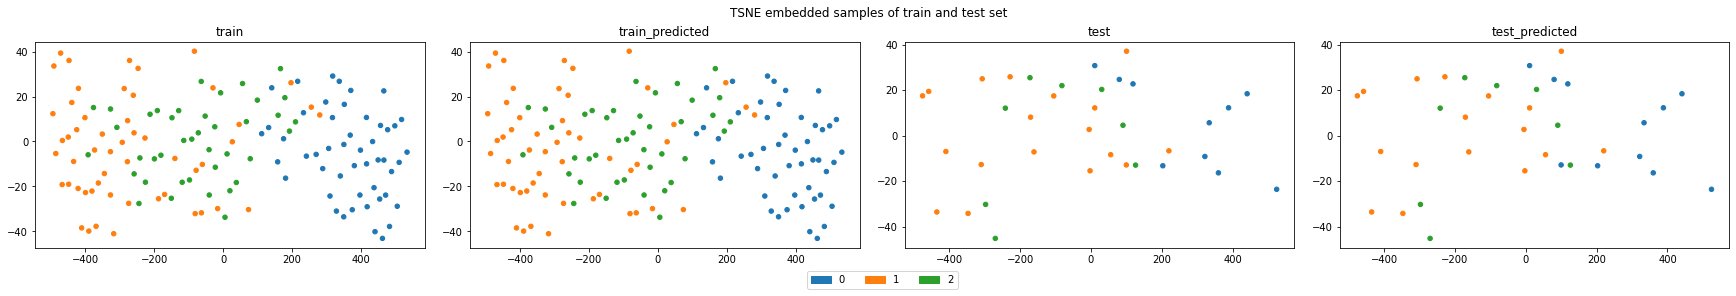

In [5]:
import numpy as np

pred_y_train = np.argmax(model.predict(transformed_dataset.x_train), axis=1)
pred_y_test = np.argmax(model.predict(transformed_dataset.x_test), axis=1)

datasets = {
    'train': (tsne_dataset.x_train, dataset.y_train),
    'train_predicted': (tsne_dataset.x_train, pred_y_train),
    'test': (tsne_dataset.x_test, dataset.y_test),
    'test_predicted': (tsne_dataset.x_test, pred_y_test)
}
plot_datasets(datasets, s=20, suptitle="TSNE embedded samples of train and test set")

## Calculating influences for small neural networks

The following sectione elaborates the calculation of influences through a neural network. It is noteworthy that the full Hessian matrix is constructed and used for inverting the gradients.

In [6]:
from valuation.influence.general import influences

test_influences = influences(model, transformed_dataset.x_test, transformed_dataset.y_test)
train_influences = influences(model, transformed_dataset.x_train, transformed_dataset.y_train, transformed_dataset.x_test, transformed_dataset.y_test)

In [7]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

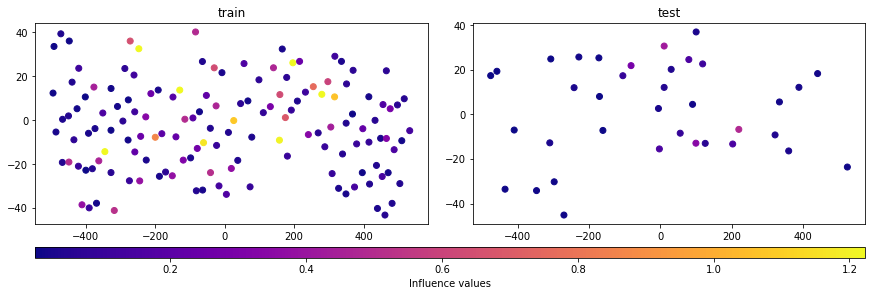

In [8]:
influence_datasets = {
    'train': (tsne_dataset.x_train, mean_train_influences),
    'test': (tsne_dataset.x_test, mean_test_influences),
}
plot_datasets(influence_datasets)

## Selecting the most influential samples

The next section selects the most influential samples and retrains the model using the shortened dataset.

In [9]:
num_shortened_samples = 100
idx = np.flip(np.argsort(mean_train_influences))[:num_shortened_samples]
shortened_dataset = copy(transformed_dataset)
shortened_dataset.x_train = shortened_dataset.x_train[idx]
shortened_dataset.y_train = shortened_dataset.y_train[idx]

In [10]:
num_classes = 3

model = PyTorchSupervisedModel(
    model=NNTorchModel(feature_dimension, num_classes, [16, 16]),
    objective=F.cross_entropy,
    num_epochs=300,
    batch_size=32,
    optimizer=PyTorchOptimizer.ADAM,
    optimizer_kwargs={
        "lr": 0.001,
        "weight_decay": 0.001,
        "cosine_annealing": True,
    },
    y_dtype=torch.long
)
model.fit(
    shortened_dataset.x_train,
    shortened_dataset.y_train
)

Training loss: 1.111079454421997
Training loss: 1.1387951374053955
Training loss: 1.0836787223815918
Training loss: 1.1325198411941528
Training loss: 1.1076912879943848
Training loss: 1.1312836408615112
Training loss: 1.0746923685073853
Training loss: 1.1210874319076538
Training loss: 1.1071070432662964
Training loss: 1.1232496500015259
Training loss: 1.065617561340332
Training loss: 1.1093497276306152
Training loss: 1.1071351766586304
Training loss: 1.1152067184448242
Training loss: 1.0568184852600098
Training loss: 1.097717046737671
Training loss: 1.1075330972671509
Training loss: 1.1073007583618164
Training loss: 1.048449993133545
Training loss: 1.086393117904663
Training loss: 1.1081355810165405
Training loss: 1.0995988845825195
Training loss: 1.0406064987182617
Training loss: 1.0755068063735962
Training loss: 1.108780026435852
Training loss: 1.09212064743042
Training loss: 1.033339023590088
Training loss: 1.0651270151138306
Training loss: 1.1092978715896606
Training loss: 1.084839